# Imports

In [1]:
%pip install --root-user-action=ignore -q segmentation-models-pytorch pytorch-lightning tabulate

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import albumentations as A
import random

import os
from tqdm import tqdm
from collections import OrderedDict

import segmentation_models_pytorch as smp
import pytorch_lightning as pl
from tabulate import tabulate

# Select GPU device for the training if available
if not torch.cuda.is_available():
    device=torch.device("cpu")
    print("Current device:", device)
else:
    device=torch.device("cuda")
    print("Current device:", device, "- Type:", torch.cuda.get_device_name(0))

Note: you may need to restart the kernel to use updated packages.
Current device: cuda - Type: Tesla P100-PCIE-16GB


In [2]:
#function for save and load in python/json objects the dictionaries
def save_pickle(dic, path):
    with open(f"{path}", 'wb') as f:
        pickle.dump(dic, f, pickle.HIGHEST_PROTOCOL)

def load_pickle(path):
    with open(f"{path}", 'rb',) as f:
        return pickle.load(f)

# create a dataframe with id of the images without extensions (.jpg)
def create_df():
    name = []
    mask = []
    for dirname, _, filenames in os.walk(IMAGE_PATH): # given a directory iterates over the files
        for filename in filenames:
            f = filename.split('.')[0]
            name.append(f)

    return pd.DataFrame({'id': name}, index = np.arange(0, len(name))).sort_values('id').reset_index(drop=True)

# Data Loaders

In [3]:
IMAGE_PATH = "../input/semantic-segmentation-drone-dataset/binary_dataset/binary_dataset/original_images/"
MASK_PATH = '../input/semantic-segmentation-drone-dataset/binary_dataset/binary_dataset/label_images_semantic/'

X = create_df()['id'].values

In [4]:
# Train Test Split
X_train, X_val = train_test_split(X, test_size=0.25, random_state=123)
X_test, X_val = train_test_split(X_val, test_size=0.4, random_state=123) # array of indexes

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  300
Val Size     :  40
Test Size    :  60


In [5]:
class DroneDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        image = np.array(Image.open(self.img_path + self.X[idx] + '.png'))
        mask = np.array(Image.open(self.mask_path + self.X[idx] + '.png')) - 1 # relabel classes from 1,2 --> 0,1 where 0 is background
        
        # augment images
        if self.transform!=None:
            aug = self.transform(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']
        
        norm = A.Normalize()(image = image, mask = np.expand_dims(mask, 0))

        return norm['image'].transpose(2, 0, 1), norm['mask']

In [6]:
t = A.Compose([A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5), A.GaussNoise(),
               A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5), p=0.4)])

# datasets
train_dataset = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, t)
valid_dataset = DroneDataset(IMAGE_PATH, MASK_PATH, X_val)
test_dataset = DroneDataset(IMAGE_PATH, MASK_PATH, X_test)

# dataloader
batch_size = 3

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dl = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Visualization

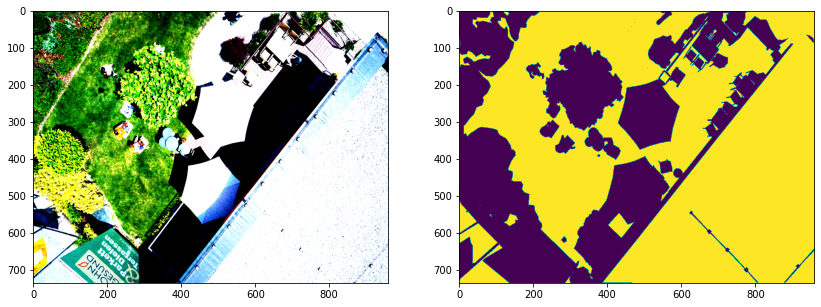

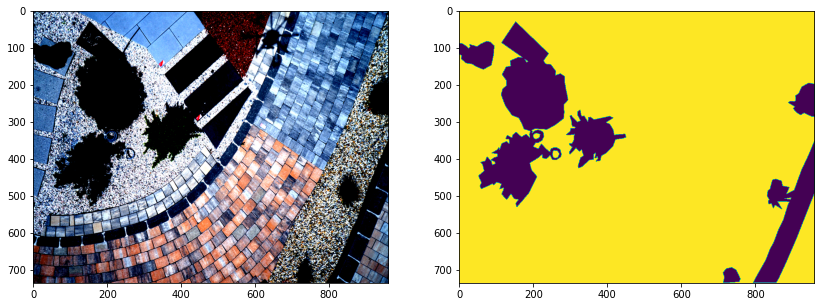

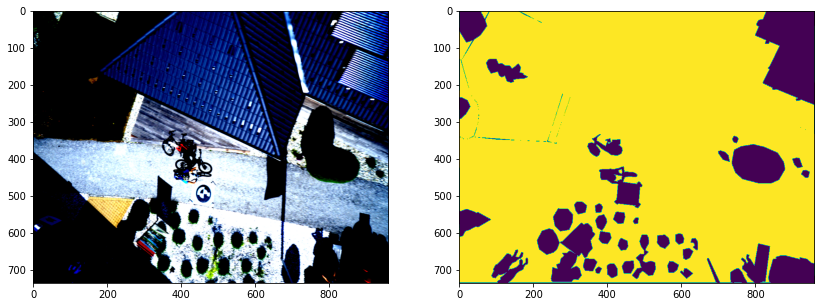

In [7]:
# lets look at some samples
image, mask = train_dataset[0]

plt.figure(figsize = (14, 10))
plt.subplot(1,2,1)
plt.imshow(np.array(image).transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(np.array(mask).squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

image, mask = valid_dataset[0]

plt.figure(figsize = (14, 10))
plt.subplot(1,2,1)
plt.imshow(np.array(image).transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(np.array(mask).squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

image, mask = test_dataset[0]

plt.figure(figsize = (14, 10))
plt.subplot(1,2,1)
plt.imshow(np.array(image).transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(np.array(mask).squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

# Model Training

In [8]:
class DroneModel(pl.LightningModule):
    def __init__(self, model, optimizer, criterion):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        
    def forward(self, x):
        return self.model(x)
    
    def shared_step(self, batch, stage):
        image, mask = batch
        out = self.forward(image)
        loss = self.criterion(out, mask.long())
        tp, fp, fn, tn = smp.metrics.get_stats((out.sigmoid() > 0.5).long(), mask.long(), mode='binary')
        iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        self.log(f"{stage}_IoU", iou, prog_bar=True, on_epoch=True)
        self.log(f"{stage}_loss", loss) 
        return {"loss": loss, "iou": iou}
        
    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")     

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")
    
    def configure_optimizers(self):
        return self.optimizer

In [9]:
arch = 'manet'
enc_name = 'efficientnet-b0'
classes = 1

model = smp.create_model(arch,
                         encoder_name = enc_name,
                         encoder_weights = "imagenet",
                         in_channels = 3,
                         classes = classes).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-03)
criterion = criterion = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
cbs = pl.callbacks.ModelCheckpoint(dirpath = f'./checkpoints_{arch}',
                                   filename = arch, 
                                   verbose = True, 
                                   monitor = 'valid_loss', 
                                   mode = 'min')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

In [10]:
pl_model = DroneModel(model, optimizer, criterion)
trainer = pl.Trainer(callbacks=cbs, accelerator='gpu', max_epochs=2, auto_lr_find=True)
trainer.fit(pl_model, train_dl, val_dl)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# Testing

In [11]:
model = smp.create_model(arch,
                         encoder_name = enc_name,
                         encoder_weights = "imagenet",
                         in_channels = 3,
                         classes = classes).to(device)

state_dict = torch.load(cbs.best_model_path)['state_dict']
pl_state_dict = OrderedDict([(key[6:], state_dict[key]) for key in state_dict.keys()])

model.load_state_dict(pl_state_dict)
model.eval()

MAnet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePaddin

In [12]:
## TESTING
with torch.no_grad(): 
    
    outputs = []
    test_loss = 0.0
    iou = 0

    for image, mask in tqdm(test_dl):       

        image = image.to(device); mask = mask.to(device)
        output = model(image).to(device)
        tp, fp, fn, tn = smp.metrics.get_stats((output.sigmoid()>0.5).long(), mask.long(), mode='binary')
        outputs.append({"tp": tp, "fp": fp, "fn": fn, "tn": tn})
        loss = criterion(output, mask.long()) 
        test_loss += loss.item() 
    
    tp = torch.cat([x["tp"] for x in outputs])
    fp = torch.cat([x["fp"] for x in outputs])
    fn = torch.cat([x["fn"] for x in outputs])
    tn = torch.cat([x["tn"] for x in outputs])
    
    print(f'Test Loss: {test_loss / len(test_dl)}')
    print('IoU:', smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise").item())

100%|██████████| 20/20 [00:05<00:00,  3.39it/s]

Test Loss: 0.08591033518314362
IoU: 0.844861626625061


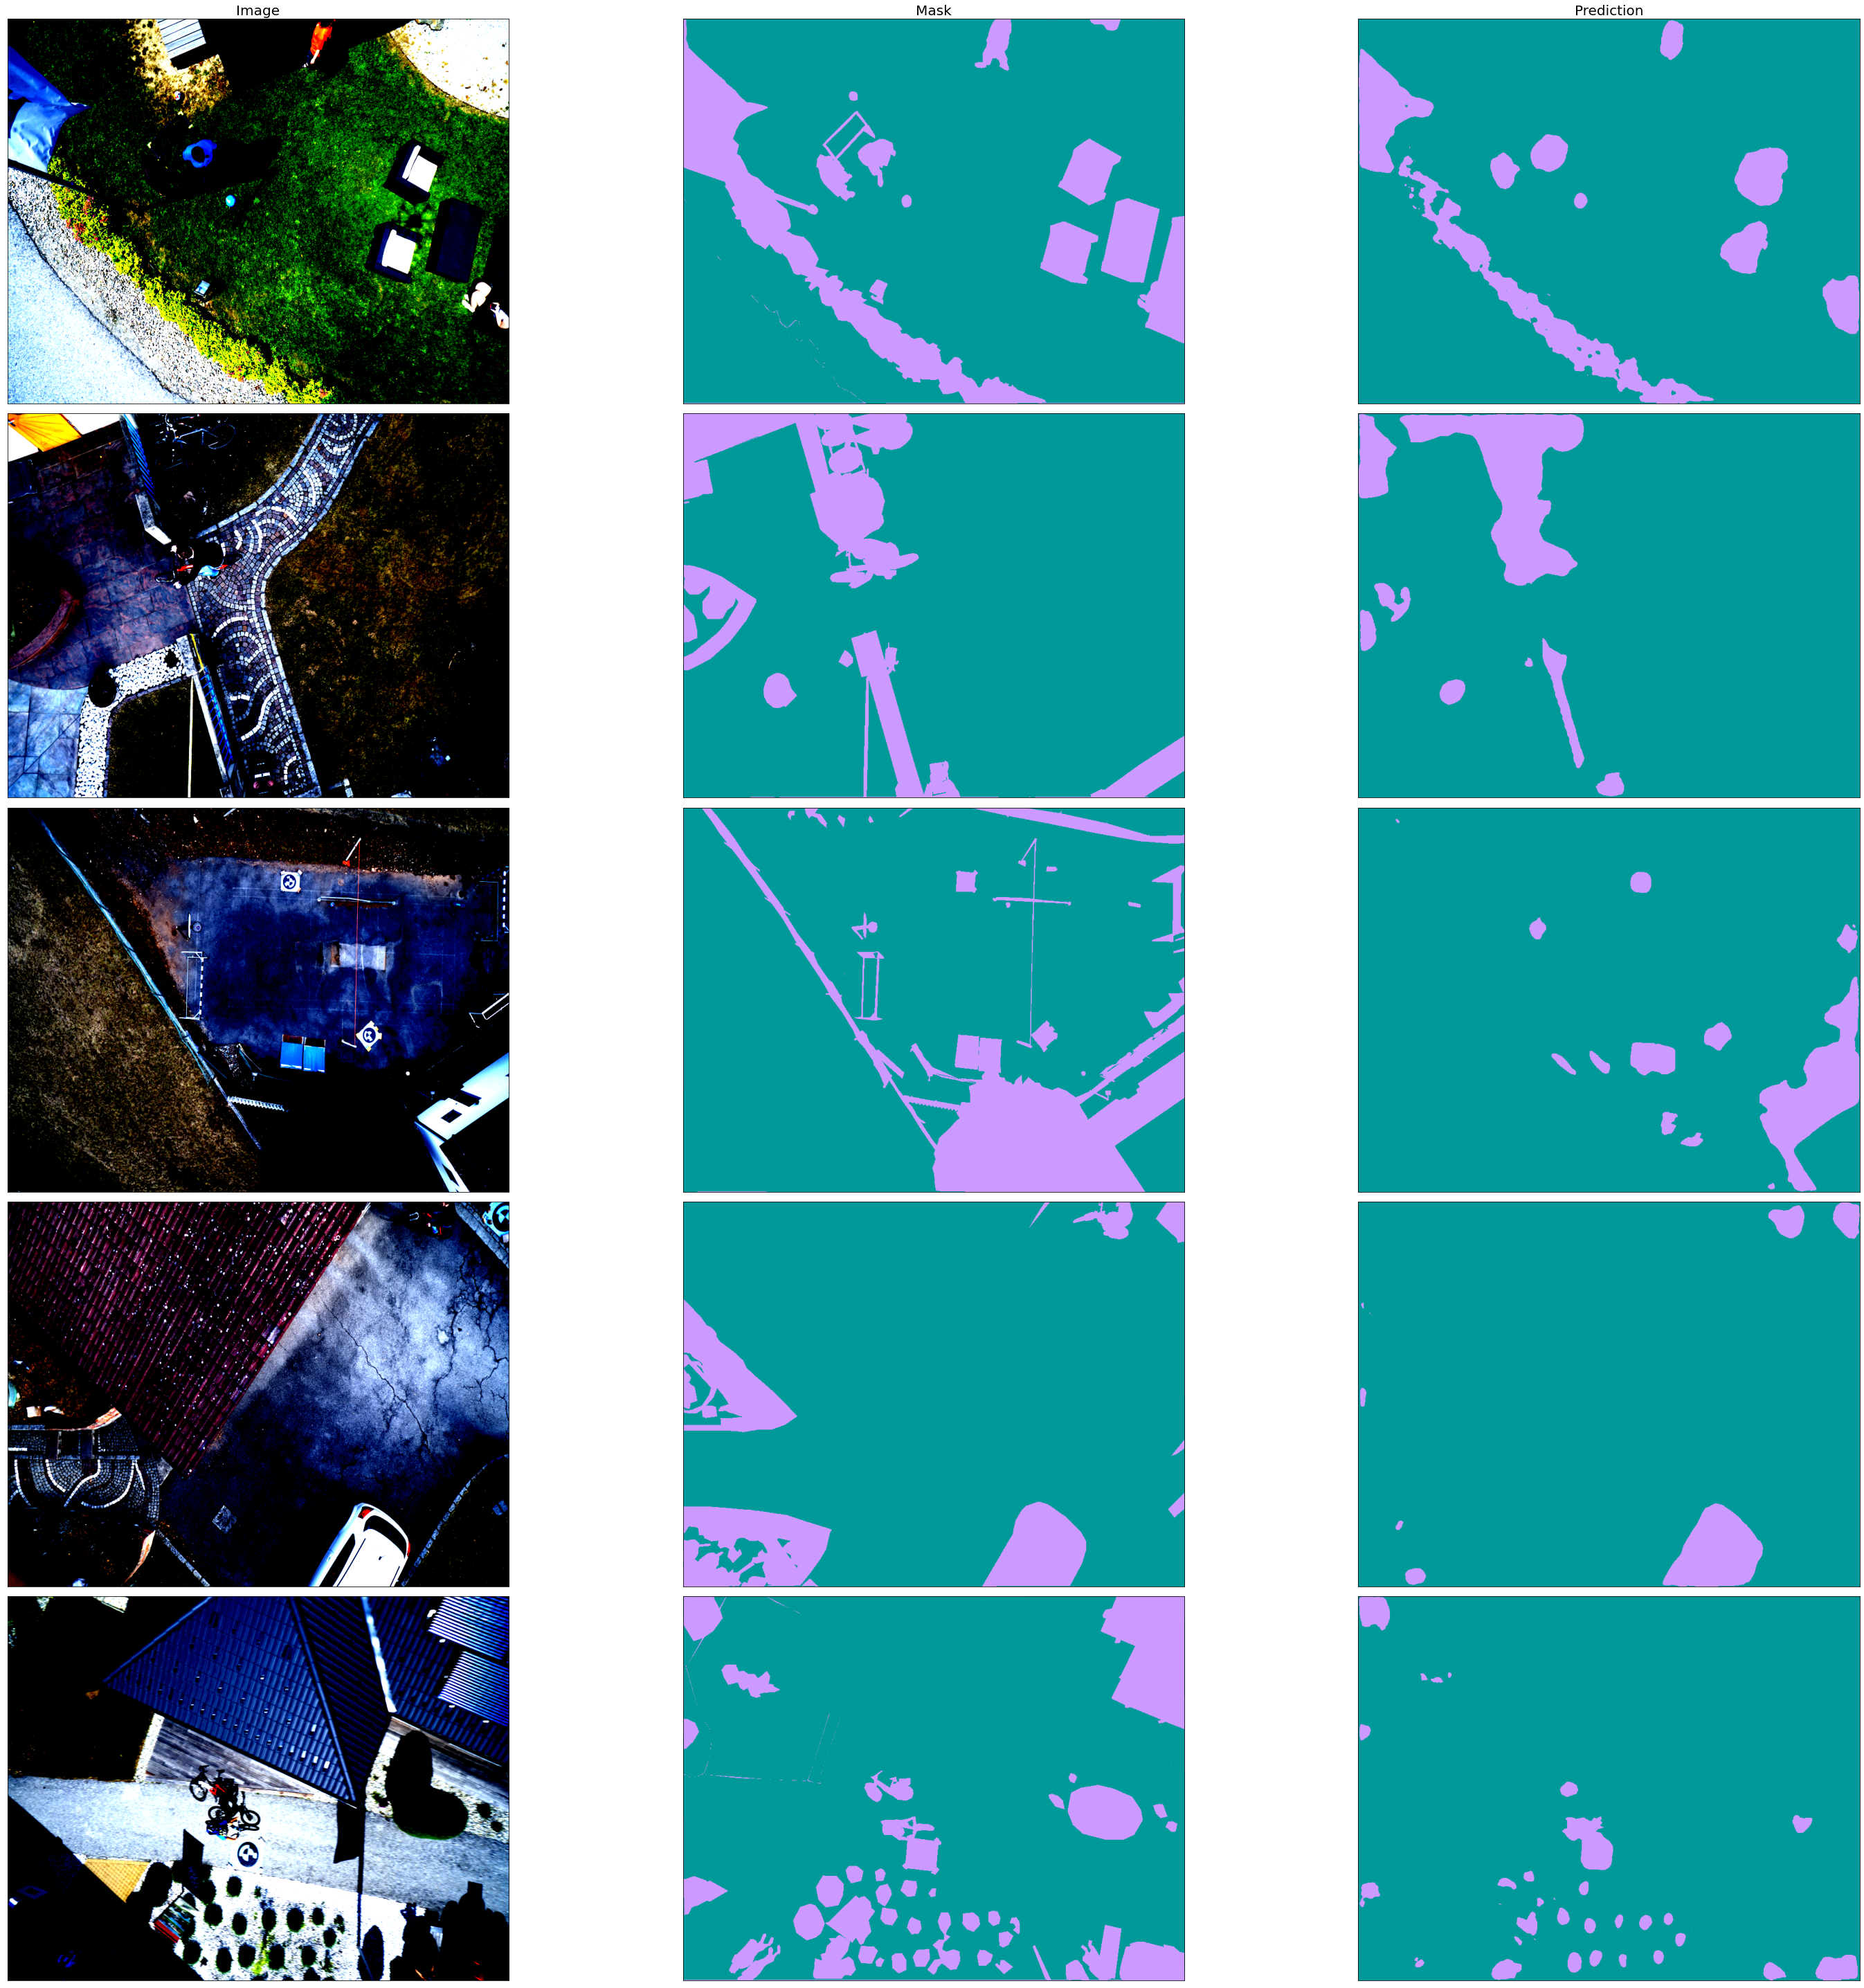

In [13]:
random.seed(10)
samples = random.sample(range(len(test_dataset)), 5)

palette = [[204,153,255], [0,153,153]]
pal = [value for color in palette for value in color]

cols = ['Image', 'Mask', 'Prediction']
fig, axes = plt.subplots(len(samples), 3, figsize=(60, 40), sharex='row', sharey='row', 
                         subplot_kw={'xticks':[], 'yticks':[]}, tight_layout=True)

for ax, col in zip(axes[0], cols): ax.set_title(col, fontsize=20) # set column label --> considered epoch

i=0
    
for i in range(len(samples)):

        image, mask = test_dataset[samples[i]]
        pred = model(torch.tensor(image).unsqueeze(0).to(device))
        pred = (pred.sigmoid() > 0.5).long().squeeze(0)  

        mask = Image.fromarray(mask.squeeze(0)).convert('P')
        pred = Image.fromarray(np.array(pred.squeeze(0).cpu()).astype('uint8')).convert('P')
        mask.putpalette(pal)
        pred.putpalette(pal)

        axes[i, 0].imshow(np.array(image).transpose(1, 2, 0));
        axes[i, 1].imshow(mask);
        axes[i, 2].imshow(pred);
        
fig.savefig(arch + '.png')

In [14]:
metrics = np.round(torch.stack([torch.mean(smp.metrics.recall(tp, fp, fn, tn, reduction=None), 0),
                                torch.mean(smp.metrics.false_positive_rate(tp, fp, fn, tn, reduction=None), 0),
                                1 - torch.mean(smp.metrics.recall(tp, fp, fn, tn, reduction=None), 0),
                                torch.mean(smp.metrics.iou_score(tp, fp, fn, tn, reduction=None), 0)]).cpu().numpy(), 3)

info = {'Recall': metrics[0], 
        'FPR': metrics[1],
        'FNR': metrics[2],
        'IoU': metrics[3]}

table = tabulate(info, headers='keys', tablefmt='fancy_grid')
print(table)

with open(f'{arch}.txt', 'w') as f:
    f.write(table)

╒══════════╤═══════╤═══════╤═══════╕
│   Recall │   FPR │   FNR │   IoU │
╞══════════╪═══════╪═══════╪═══════╡
│    0.985 │ 0.582 │ 0.015 │ 0.845 │
╘══════════╧═══════╧═══════╧═══════╛
